In [1]:
import gym
import torch
from darc import DARC
from sac import ContSAC
from broken_joint import BrokenJointEnv
import matplotlib.pyplot as plt
import numpy as np
from utils import *

env_name = 'HalfCheetah-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

device = 'cuda'

state dim is: 17 and action dim is: 6


In [2]:
policy_config = {
    "input_dim": [state_dim],
    "architecture": [{"name": "linear1", "size": 256},
                     {"name": "linear2", "size": 256},
                     {"name": "split1", "sizes": [action_dim, action_dim]}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
value_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 256},
                     {"name": "linear2", "size": 256},
                     {"name": "linear2", "size": 1}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sa_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sas_config = {
    "input_dim": [state_dim * 2 + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}

# broken source

In [3]:
env_name = 'HalfCheetah-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

state dim is: 17 and action dim is: 6


In [4]:
# set current device
torch.cuda.set_device(0)
device = 'cuda'

In [4]:
running_state = ZFilter((state_dim,), clip=10)
model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, "cuda", ent_adj=True,
             n_updates_per_train=1,lr=3e-4,max_steps=200,batch_size=256,
             savefolder='broken_source_half_cheetah_200steps',running_mean=running_state,if_normalize = True)

src, tgt = model.train(5000, deterministic=False)

TARGET: index: 0, steps: 201, total_rewards: -5.398591336098452
SOURCE: index: 0, steps: 201, total_rewards: 1.4311282819186122
TARGET: index: 1, steps: 201, total_rewards: -116.954339783454
SOURCE: index: 1, steps: 201, total_rewards: -43.48498433277721
TARGET: index: 2, steps: 201, total_rewards: -87.42794531337888
SOURCE: index: 2, steps: 201, total_rewards: -90.60279665506478
TARGET: index: 3, steps: 201, total_rewards: -83.36872479999006
SOURCE: index: 3, steps: 201, total_rewards: -30.092369426677152
TARGET: index: 4, steps: 201, total_rewards: -74.13124746707706
SOURCE: index: 4, steps: 201, total_rewards: -58.59415636932736
TARGET: index: 5, steps: 201, total_rewards: -44.797872565703685
SOURCE: index: 5, steps: 201, total_rewards: -16.20891706528925
TARGET: index: 6, steps: 201, total_rewards: -53.71674024375893
SOURCE: index: 6, steps: 201, total_rewards: -57.55232235476372
TARGET: index: 7, steps: 201, total_rewards: -78.187341348749
SOURCE: index: 7, steps: 201, total_rewar

KeyboardInterrupt: 

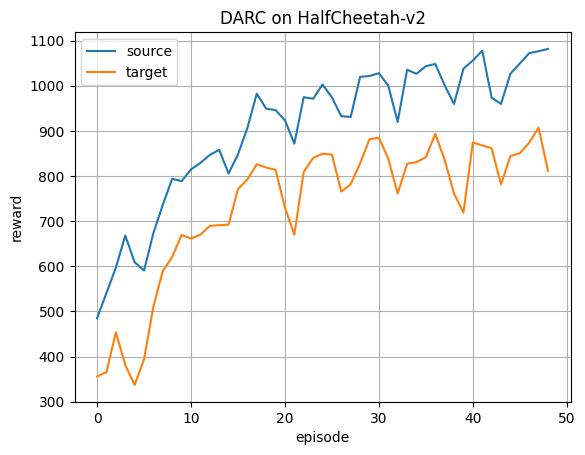

In [12]:
length = list(range(len(src)))
plt.plot(length, src, label="source")
plt.plot(length, tgt, label="target")
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("DARC on HalfCheetah-v2")
plt.legend()
plt.grid()
plt.show()

# Sample Expert trajectory and save

In [5]:
import gym
import argparse
import numpy as np
from darc import DARC
from broken_joint import BrokenJointEnv
import os
import torch
from utils import *
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import sys
import pickle
import time
from src_gailsac_classifier_snips import GailContSAC_SRC_Classifier

In [6]:
render = 'store_true'
log_std = -0.0
gamma = 0.99
tau = 0.95
lr_reg = 1e-3
learning_rate = 5e-5
clip_epsilon = 0.01
num_threads = 1
seed = 1
min_batch_size = 2048
eval_batch_size = 2048
max_iter_num = 15000
log_interval = 1
save_model_path = ''
max_expert_state_num = 1000
train_steps = 2000
episode_length = 200
save_file_name = ''
optim_epochs = 3


env_name = "HalfCheetah-v2"
env = gym.make(env_name)

def lr_decay(actor_optim,cirtic_optim, total_steps,max_steps):
    if total_steps > 7000:
        lr_a_now = learning_rate * (1 - (total_steps-7000) /(max_steps))
        for p in actor_optim.param_groups:
            p['lr'] = lr_a_now
        for p in cirtic_optim.param_groups:
            p['lr'] = lr_a_now
    return actor_optim,cirtic_optim



In [7]:
save_model = 'broken_source_half_cheetah_200steps_eval_target_1136/4900'


expert_model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, device, ent_adj=True,
             n_updates_per_train=1, max_steps = 200, batch_size=256, savefolder ='none') 
expert_model.load_model(save_model, device)
expert_model.running_mean.fix = True


In [8]:
num_steps = 0
expert_traj = []
total_reward = 0
from tqdm import tqdm

for i_episode in tqdm(range(100000)):

    state = source_env.reset()
    state = expert_model.running_mean(state)
    reward_episode = 0

    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = source_env.step(action)
        next_state = expert_model.running_mean(next_state)
        reward_episode += reward
        num_steps += 1

        expert_traj.append(np.hstack([state, next_state]))
        

        if done or num_steps >= max_expert_state_num:
            break


        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode

    # print('Episode {}\t reward: {:.2f} \t step : {}'.format(i_episode, reward_episode,t))
print('eval on src',total_reward/(i_episode))
expert_traj = np.stack(expert_traj)

total_reward = 0
num_steps = 0
for i_episode in tqdm(range(50)):
    state = target_env.reset()
    state = expert_model.running_mean(state)
    reward_episode = 0
    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = target_env.step(action)
        next_state = expert_model.running_mean(next_state)
        reward_episode += reward
        num_steps += 1
        if done or num_steps >= max_expert_state_num:
            break
        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode
print('eval on tgt',total_reward/(i_episode))

  0%|          | 4/100000 [00:00<4:15:33,  6.52it/s]


eval on src 1191.89119970723


  8%|▊         | 4/50 [00:00<00:06,  7.03it/s]

eval on tgt 1141.2146145124611


In [15]:
IL = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 50,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs, tgt_bs, classifier_loss, discrimiator_loss = IL.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -7.962546907780584, total_reward_adv: -7.9625, acc gen: 0, acc expert: 0
eval reward: -1.0166525938040452
index: 1, steps: 201, total_rewards: 5.256109938476777, total_reward_adv: 5.2561, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -76.23073145002942, total_reward_adv: -76.2307, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -50.98876398966623, total_reward_adv: -50.9888, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -73.7227443573764, total_reward_adv: -73.7227, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -55.872286260323676, total_reward_adv: -55.8723, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: 33.40658048716759, total_reward_adv: 33.4066, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -45.47854471731011, total_reward_adv: -45.4785, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: 0.6923862023431823, total_reward_adv: 0.6924, ac

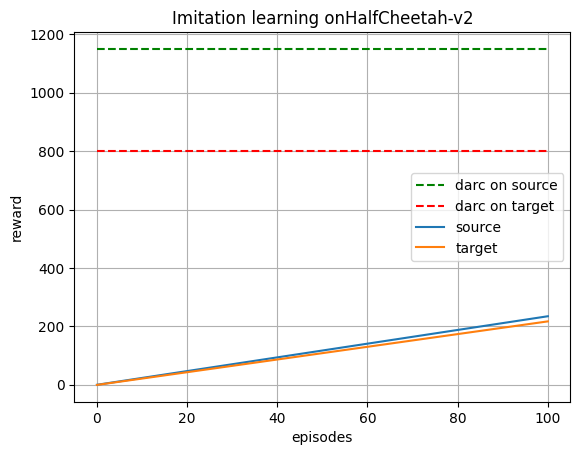

In [ ]:
length = np.array(list(range(len(src_bs)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs, label="source")
plt.plot(length, tgt_bs, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


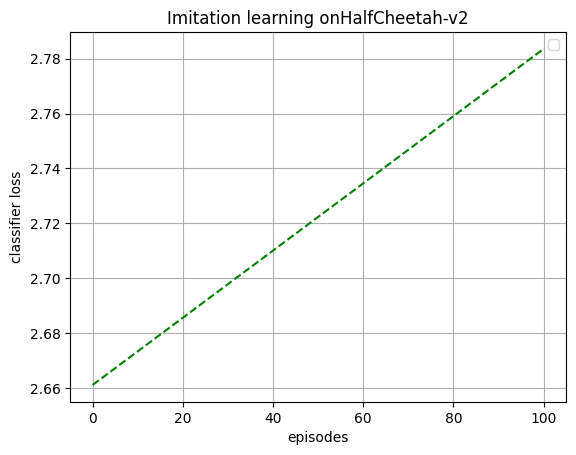

In [ ]:
loss_length = np.array(list(range(len(classifier_loss)))) * 100
plt.plot(loss_length, classifier_loss, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


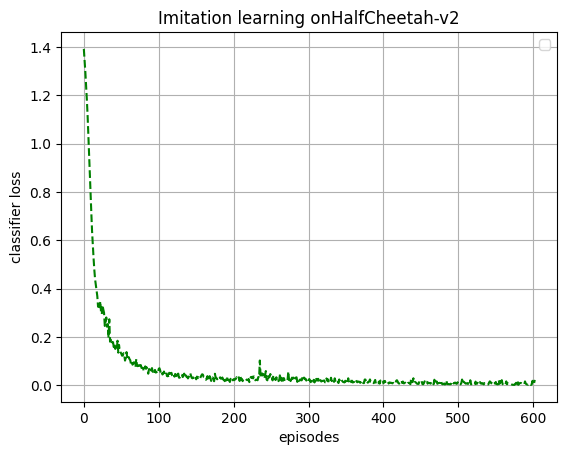

In [ ]:
loss_length = np.array(list(range(len(discrimiator_loss))))
plt.plot(loss_length, discrimiator_loss, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [ ]:
IL2 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10000,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs2, tgt_bs2, classifier_loss2, discrimiator_loss2 = IL2.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -24.975735022637497, total_reward_adv: -69.4782, acc gen: 0, acc expert: 0
eval reward: -1.317047511110712
index: 1, steps: 201, total_rewards: -84.98142391249554, total_reward_adv: -144.2274, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -66.05437712269809, total_reward_adv: -116.9036, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -73.25701426025068, total_reward_adv: -132.0967, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: 5.452464960185597, total_reward_adv: -36.403, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -31.324070509496913, total_reward_adv: -67.3364, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -53.64424392258173, total_reward_adv: -107.6741, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -9.526369632693854, total_reward_adv: -54.2029, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -46.3281357496279, total_reward_adv: -1

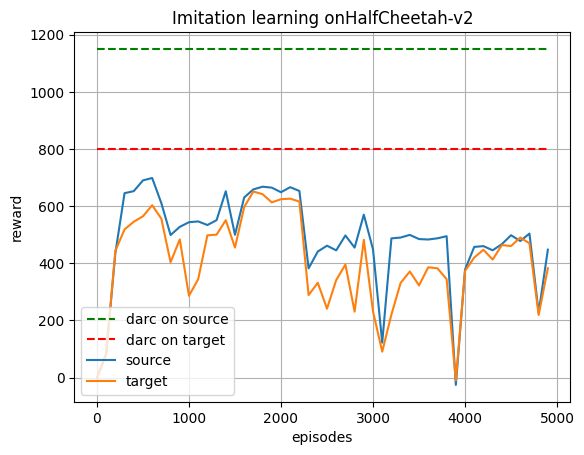

In [ ]:
length = np.array(list(range(len(src_bs2)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs2, label="source")
plt.plot(length, tgt_bs2, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


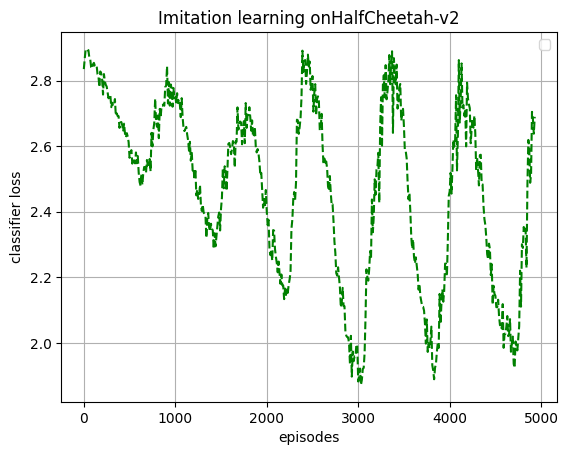

In [ ]:
loss_length_2 = np.array(list(range(len(classifier_loss2)))) * 100
plt.plot(loss_length_2, classifier_loss2, 'g--')


plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [21]:
IL3 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10000,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs3, tgt_bs3, classifier_loss3, discrimiator_loss3 = IL3.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -16.808891518716504, total_reward_adv: -46.3535, acc gen: 0, acc expert: 0
eval reward: -0.3946021891005014
index: 1, steps: 201, total_rewards: -8.201520393026758, total_reward_adv: -115.3298, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -75.09758478573806, total_reward_adv: -113.4907, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -37.95584617780534, total_reward_adv: -64.9382, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -37.324815527470946, total_reward_adv: -69.6538, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -7.333105360496206, total_reward_adv: -87.4348, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -16.349681273259645, total_reward_adv: -50.8644, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -18.428667985574872, total_reward_adv: -44.9725, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -73.6782095217105, total_reward_adv:

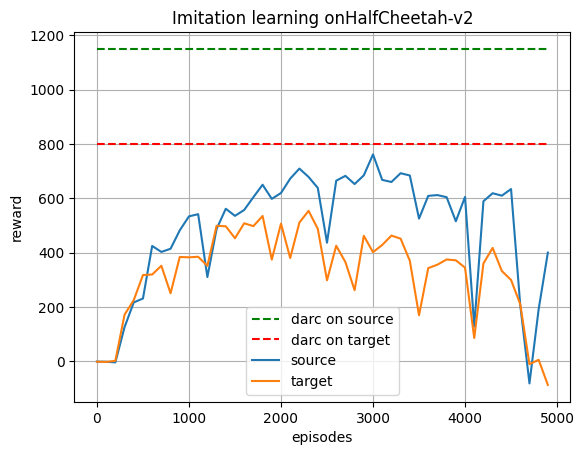

In [23]:
length = np.array(list(range(len(src_bs_3)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_3, label="source")
plt.plot(length, tgt_bs_3, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


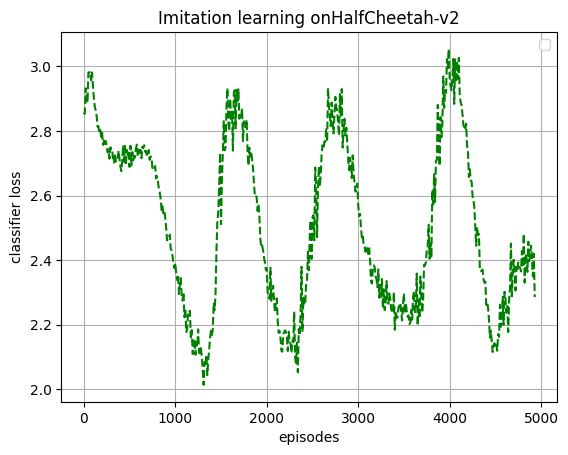

In [22]:
loss_length_3 = np.array(list(range(len(classifier_loss_3)))) * 10
plt.plot(loss_length_3, classifier_loss_3, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [23]:
IL_4 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 5e-5, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, 
                                    clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs_4, tgt_bs_4, classifier_loss_4 = IL_4.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -63.69695082995994, total_reward_adv: -3.3891, acc gen: 0, acc expert: 0
eval reward: -0.20284676009701844
index: 1, steps: 201, total_rewards: -55.97335882900075, total_reward_adv: 8.0876, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -57.509436328185856, total_reward_adv: -5.7779, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -65.88127599128804, total_reward_adv: -10.7726, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: 6.8453094243515995, total_reward_adv: 44.1889, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -57.84011401392815, total_reward_adv: -7.5273, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -55.47712949808745, total_reward_adv: -1.0729, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -39.59486053538327, total_reward_adv: 8.6594, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -96.28480268181347, total_reward_adv: -30.4773, a

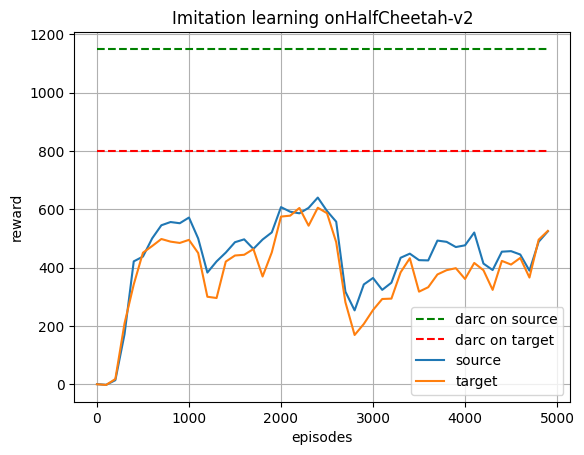

In [24]:
length = np.array(list(range(len(src_bs_4)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_4, label="source")
plt.plot(length, tgt_bs_4, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


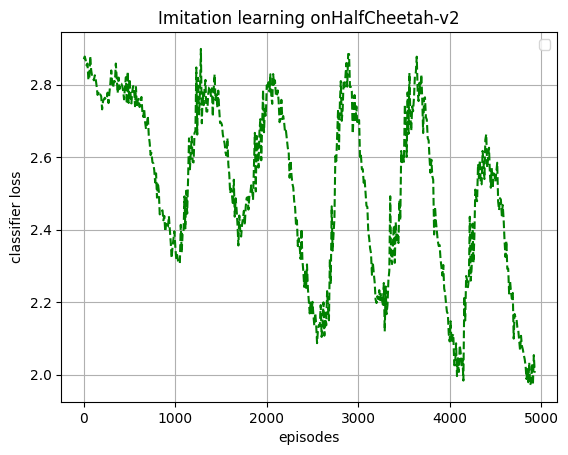

In [25]:
loss_length_4 = np.array(list(range(len(classifier_loss_4)))) * 10
plt.plot(loss_length_4, classifier_loss_4, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [26]:
IL_5 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, 
                                    clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs_5, tgt_bs_5, classifier_loss_5 = IL_5.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -20.071351152497474, total_reward_adv: -84.9237, acc gen: 0, acc expert: 0
eval reward: -0.43797576420315065
index: 1, steps: 201, total_rewards: -3.7638024026844485, total_reward_adv: -60.6986, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -9.304003650198393, total_reward_adv: -75.4992, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -59.43307985448953, total_reward_adv: -142.289, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -11.775509470527155, total_reward_adv: -73.2019, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: 6.246257624936404, total_reward_adv: -56.4759, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -23.045911313180085, total_reward_adv: -85.2151, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -86.74823782444443, total_reward_adv: -173.2907, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -71.56045788531442, total_reward_adv:

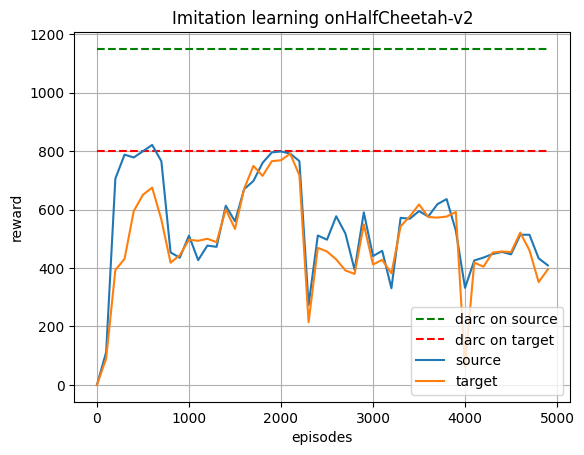

In [27]:
length = np.array(list(range(len(src_bs_5)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_5, label="source")
plt.plot(length, tgt_bs_5, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


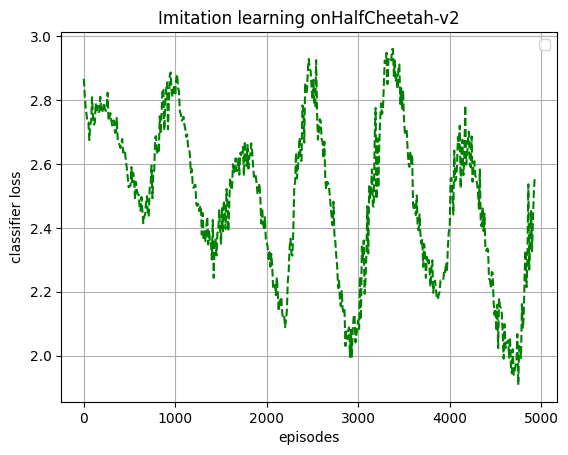

In [28]:
loss_length_5 = np.array(list(range(len(classifier_loss_5)))) * 10
plt.plot(loss_length_5, classifier_loss_5, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [29]:
IL_6 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10,
                                    if_normalize=True, clamp_reward_lower_bound = 0.2, 
                                    clamp_reward_upper_bound = 5,
                               reward_type = 2)

src_bs_6, tgt_bs_6, classifier_loss_6 = IL_6.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -24.463966493417647, total_reward_adv: -49.2914, acc gen: 0, acc expert: 0
eval reward: -1.6694646753338223
index: 1, steps: 201, total_rewards: -43.05209135473305, total_reward_adv: -75.9808, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -35.4531882805207, total_reward_adv: -78.6718, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -74.34499472913456, total_reward_adv: -109.2757, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -64.6522970561997, total_reward_adv: -99.1434, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -45.9799070221989, total_reward_adv: -78.3753, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -55.98367194215826, total_reward_adv: -87.0757, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -34.93579803316272, total_reward_adv: -66.9766, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -82.75629880865003, total_reward_adv: -121.

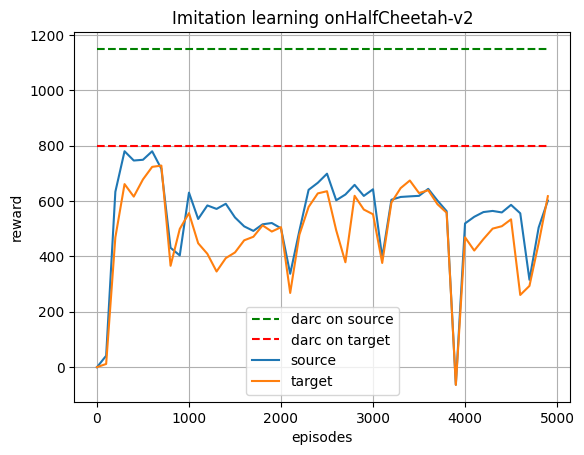

In [30]:
length = np.array(list(range(len(src_bs_6)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_6, label="source")
plt.plot(length, tgt_bs_6, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


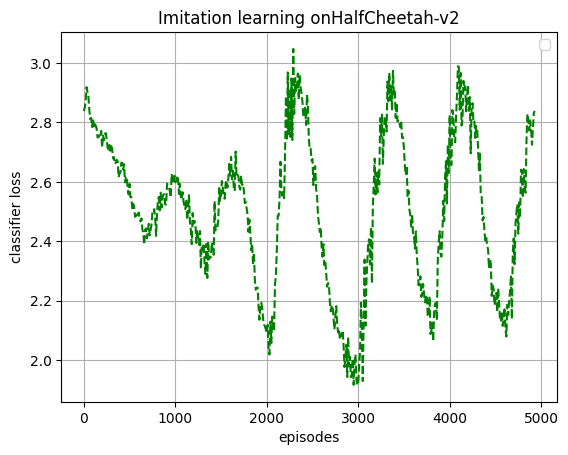

In [31]:
loss_length_6 = np.array(list(range(len(classifier_loss_6)))) * 10
plt.plot(loss_length_6, classifier_loss_6, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [32]:
IL_7 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 100,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, 
                                    clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs_7, tgt_bs_7, classifier_loss_7 = IL_7.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -47.48615122194333, total_reward_adv: -90.6175, acc gen: 0, acc expert: 0
eval reward: -0.9394007711052399
index: 1, steps: 201, total_rewards: -97.2347855124923, total_reward_adv: -156.9015, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -63.91805829927729, total_reward_adv: -117.2538, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -23.60061224898344, total_reward_adv: -64.0582, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -47.439663693488214, total_reward_adv: -91.5383, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -58.08537448146057, total_reward_adv: -106.665, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -1.2706040197651596, total_reward_adv: -31.2827, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -56.49732211809426, total_reward_adv: -107.6705, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -75.66491362012647, total_reward_adv: 

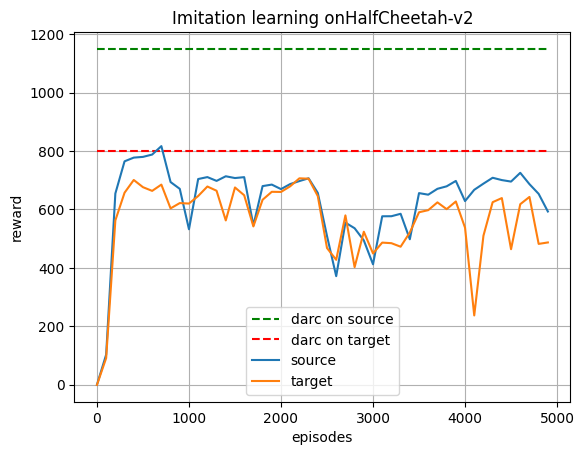

In [33]:
length = np.array(list(range(len(src_bs_7)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_7, label="source")
plt.plot(length, tgt_bs_7, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


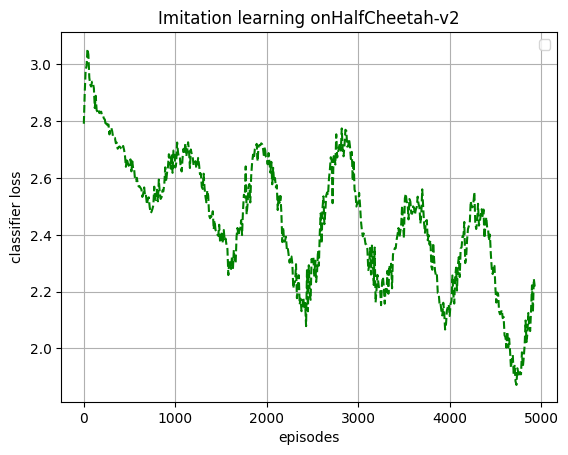

In [35]:
loss_length_7 = np.array(list(range(len(classifier_loss_6)))) * 10
plt.plot(loss_length_7, classifier_loss_7, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [34]:
IL_8 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 1000,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, 
                                    clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs_8, tgt_bs_8, classifier_loss_8 = IL_8.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -19.063667326897356, total_reward_adv: 3.6813, acc gen: 0, acc expert: 0
eval reward: -0.7875960389360087
index: 1, steps: 201, total_rewards: -31.560825919008327, total_reward_adv: -8.7452, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -73.68412070483522, total_reward_adv: -42.5583, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -48.6473836003241, total_reward_adv: -26.1805, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -52.01792692534552, total_reward_adv: -20.3665, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -42.784719871301704, total_reward_adv: -14.113, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -38.80348757469918, total_reward_adv: -6.4209, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -75.63717324528517, total_reward_adv: -47.2564, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -63.58002879857101, total_reward_adv: -42.889

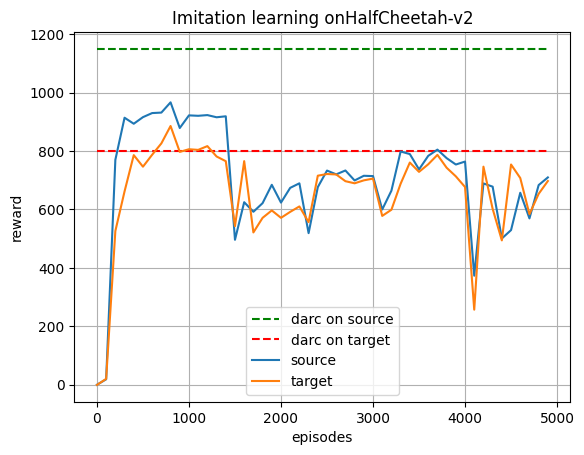

In [36]:
length = np.array(list(range(len(src_bs_8)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_8, label="source")
plt.plot(length, tgt_bs_8, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


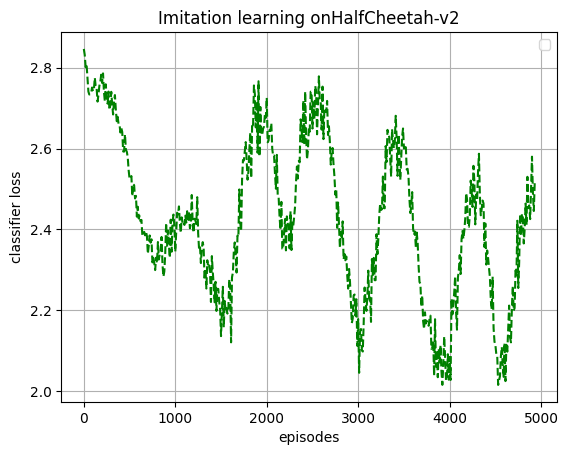

In [37]:
loss_length_8 = np.array(list(range(len(classifier_loss_8)))) * 10
plt.plot(loss_length_8, classifier_loss_8, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [39]:
IL_9 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10000,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, 
                                    clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs_9, tgt_bs_9, classifier_loss_9 = IL_9.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -41.637296620434924, total_reward_adv: 19.2159, acc gen: 0, acc expert: 0
eval reward: -0.6968785437612245
index: 1, steps: 201, total_rewards: -38.92237988003722, total_reward_adv: 19.681, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -35.59337055628678, total_reward_adv: 24.3221, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -28.116407739194994, total_reward_adv: 29.4816, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -20.83912829884391, total_reward_adv: 33.7581, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -27.924116309000787, total_reward_adv: 27.5927, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -15.20060971242625, total_reward_adv: 37.3022, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -33.99046420656313, total_reward_adv: 25.185, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -126.80034373075074, total_reward_adv: -31.3336, 

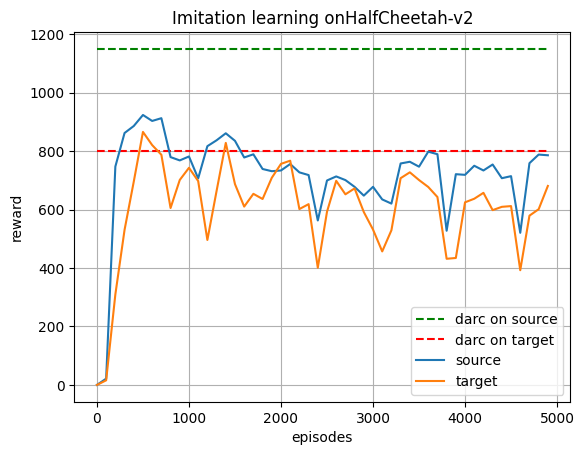

In [40]:
length = np.array(list(range(len(src_bs_9)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_9, label="source")
plt.plot(length, tgt_bs_9, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


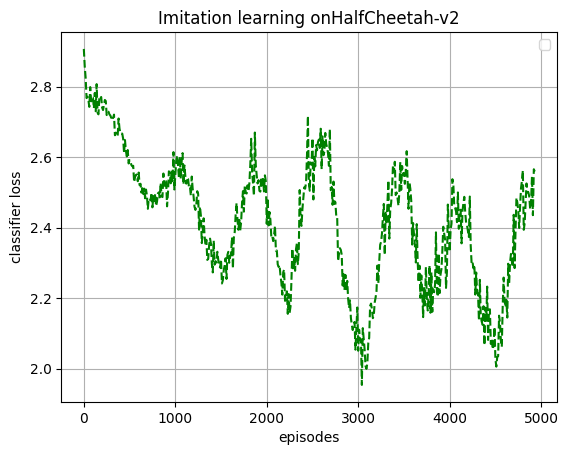

In [41]:
loss_length_9 = np.array(list(range(len(classifier_loss_9)))) * 10
plt.plot(loss_length_9, classifier_loss_9, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()